# Multi-Layered Perceptron tramite keras

Esistono due tipi di Api per descrivere i modelli: sequenziale e funzionale.

In una __Api sequenziale__ il modello viene specificato tramite una lista lista di layers, i quali formeranno un grafo computazionale con struttura lineare. L'input alimenta il primo layer della lista, a sua volta alimenta il secondo e così via. 
L'api è puramente dichiarativa, le variabili intermedie (corrispondono alle attivazioni negli strati nascosti) non compaiono nella specifica del modello. 
Il _vantaggio_ è l'estrema semplicità con cui definisco il modello, ma lo _svantaggio_ è la limitata flessibilità nella costruzione del grafo computazionale (continua a avere una struttura lineare).

Le __Api funzionali__ permettono di descrivere anche grafi complessi, quindi posso definire blocchi di nodi di calcolo e riusarli, alimentare un layer con le uscite di due o più layer, implementare forme arbitrarie di condivisone di pesi e varie altre cose.
Il flusso di operazioni effettuate deve essre scritto esplicitamnete, le variabili di out e in compaiono esplicitamente nel codice.

Useremo __Keras__, è un api di alto livello implementata in Tensorflow. Consente di vedere la dichiarazione dei modelli e l'addestramento a diversi livelli di granularità. Ha funzioni semplici da usare che possono essere customizzate, se necessario. 

In [1]:
from types import SimpleNamespace

import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, ReLU

from tensorflow.keras import losses
from tensorflow.keras import optimizers

Definiamo una funzione che crea e ritorna un modello.

In [2]:
def mlp_sequential(num_classes, input_dim, opts):
    model = Sequential()  # lista di layers vuota, li aggiungo con il metodo add
    model.add(Input((input_dim,)))  # input layer, specifico la dimensione dell'input
    for hidden_dim in opts.layer_sizes:
        model.add(Dense(hidden_dim))  # layer dense, è pienamente connesso
        model.add(ReLU())  # funzione di attivazione
    model.add(Dense(num_classes))  # classification head del modello
    model.compile(loss=losses.CategoricalCrossentropy(from_logits=True), # from_logits true per avere stabilità numerica
                  optimizer=optimizers.SGD(
                      learning_rate=opts.learning_rate,
                      momentum=opts.momentum),
                  metrics=['accuracy']) # le metriche saranno calcolate e visualizzate durante l'apprendimento
    return model   

Definizione dei parametri che verranno utilizzati. Questi valori sono arbitrari, ma hanno senso in questo caso.

In [13]:
from types import SimpleNamespace

opts = SimpleNamespace(
dataset = 'mnist',
learning_rate = 0.002,
momentum = 0.95,
num_epochs = 20,
batch_size = 128,
layer_sizes = [700, 500, 500]
)

Sistemiamo i dati in modo da poter eseguire correttamente l'addestramento

In [11]:
# load dataset
from tensorflow.keras.datasets import mnist
import numpy as np

(X_train, y_train), (X_test, y_test) = mnist.load_data()

# da matrice a vettore
input_dim = np.prod(X_train.shape[1:]) # appiattisco la matrice in un vettore dato che MLP lavora con vettori
X_train = X_train.reshape(-1, input_dim)
X_test = X_test.reshape(-1, input_dim)

# normalizzo i dati
X_train = X_train/255
X_test = X_test/255

# one-hot encoding
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Costruiamo il modello

In [16]:
model = mlp_sequential(num_classes=y_train.shape[1], input_dim=input_dim, opts=opts)
model.summary() # visualizzo la struttura del modello

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 700)            │       549,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 500)            │       350,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 500)            │       250,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         5,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,155,510 (4.41 MB)

 Trainable params: 1,155,510 (4.41 MB)

 Non-trainable params: 0 (0.00 B)

Passiamo all'ottimizzazione del modello, viene fatta tramite il metodo `fit`.

Al termine di ciiascuna epoca ho il valore di accuratezza e loss.

In [22]:
history = model.fit(X_train, y_train, epochs=opts.num_epochs, batch_size=opts.batch_size, validation_data=(X_test, y_test))

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9999 - loss: 0.0036 - val_accuracy: 0.9802 - val_loss: 0.0705
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9998 - loss: 0.0037 - val_accuracy: 0.9797 - val_loss: 0.0703
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 0.9799 - val_loss: 0.0713
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.9797 - val_loss: 0.0723
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 0.9800 - val_loss: 0.0721
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9999 - loss: 0.0027 - val_accuracy: 0.9798 - val_loss: 0.0737
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9999 - loss: 0.0027 - val_accuracy: 0.9790 - val_loss: 0.0726
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0

In [19]:
loss_and_acc = model.evaluate(X_test, y_test, batch_size=opts.batch_size)
print(f"Loss: {loss_and_acc[0]}, Accuracy: {loss_and_acc[1]}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9757 - loss: 0.0858
Loss: 0.06956718116998672, Accuracy: 0.9799000024795532


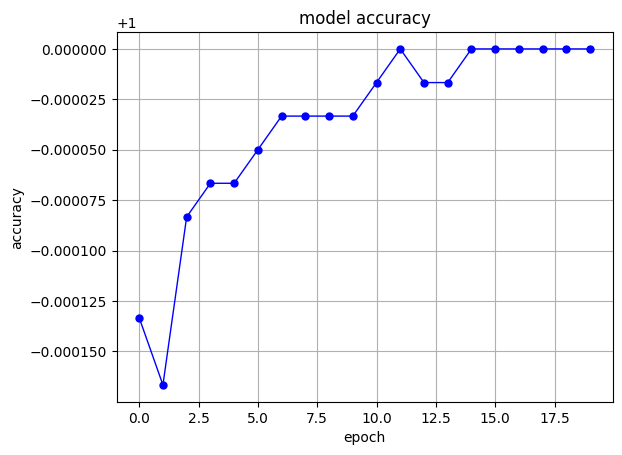

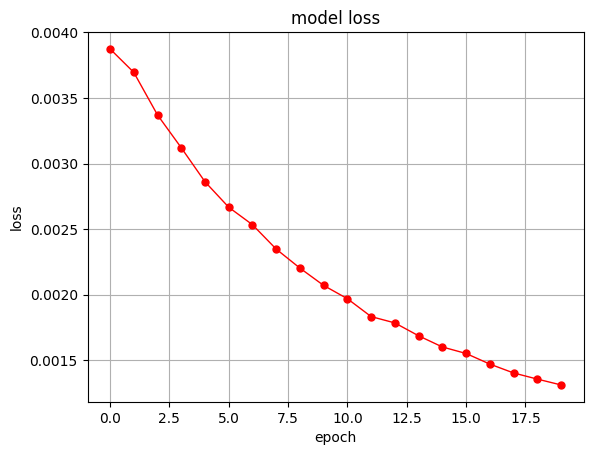

In [36]:
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
loss = history.history['loss']

# plot accuracy over epochs
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(accuracy, marker='o', color='b', linestyle='-', linewidth=1, markersize=5)
plt.grid(True)
plt.show()

# plot loss over epochs
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(loss, marker='o', color='r', linestyle='-', linewidth=1, markersize=5)
plt.grid(True)
plt.show()